# Import and Download

In [ ]:
import time
import os
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torchvision.utils as utils
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.init import xavier_uniform
import tqdm
from IPython import display
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
from tqdm.notebook import tqdm, trange

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# !rm -rf covid19-radiography-database.zip
# !rm -rf COVID-19_Radiography_Dataset
# !rm -rf train_data

In [ ]:
%%capture
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database
!unzip covid19-radiography-database.zip

In [ ]:
import os 
DATASET_DIR = "./COVID-19_Radiography_Dataset"
os.listdir(DATASET_DIR)

['Normal',
 'README.md.txt',
 'COVID.metadata.xlsx',
 'Normal.metadata.xlsx',
 'Viral Pneumonia',
 'Viral Pneumonia.metadata.xlsx',
 'COVID',
 'Lung_Opacity',
 'Lung_Opacity.metadata.xlsx']

In [ ]:
!mkdir train_data
!cp -R "./COVID-19_Radiography_Dataset/COVID" "train_data"
!cp -R "./COVID-19_Radiography_Dataset/Normal" "train_data"


mkdir: cannot create directory ‘train_data’: File exists


In [ ]:
print("number of covid: {}, normal: {}".format(len(os.listdir("train_data/COVID")), len(os.listdir("train_data/Normal"))))

number of covid: 3616, normal: 10192


Randomly select half normal images to avoid RAM overload (crushed several times even after reducing image size to 128*128)

In [ ]:
!find  "train_data/Normal" -type f -print0 | sort -zR | tail -zn +3618 | xargs -0 rm

# Load Images

[Torch image transformers](https://pytorch.org/vision/stable/transforms.html?highlight=transform)

In [ ]:
TRAIN_DIR = "train_data"
preload = transforms.Compose([
                              transforms.ToTensor()
                              ])
data = ImageFolder(TRAIN_DIR, transform=preload)



---
Do not run this section. Will crash Colab. Only for finding the mean, std for normalization.


In [ ]:
print("total number of images", len(data))
print("list of all classes", data.classes)

total number of images 7233
list of all classes ['COVID', 'Normal']


In [ ]:
run = False
if run:
  sizes = set()
  labels = []
  images = []
  for img,label in data:
    sizes.add(img.shape)
    images.append(img)
    labels.append(label)

In [ ]:
if run:
  images = torch.cat(images, dim=1)
  print("image shapes: {}, mean: {}, variance: {}".format(sizes, torch.mean(images,view(3,-1), dim=1), torch.var(images.view(3,-1), dim=1)))
  print("labels", Counter(labels))

Images all of size (3, 299, 299). Three labels.

# Train Test Split & Utils(Run this)



In [ ]:
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
train_data, test_set = torch.utils.data.random_split(data, [5810, 1423]) # .8/.2 train/test
train_set, val_set = torch.utils.data.random_split(train_data, [4648, 1162]) # 0.8/0.2 train/val
print(len(train_set))
print(len(val_set))

4648
1162


In [ ]:
def get_data_loader(train_set, val_set, test_set, batchsize=64, sampler_train=None, sampler_val=None):
  shuffle = True

  if sampler_train:
    shuffle=False

  train_loader = DataLoader(train_set, batch_size=batchsize,
                            shuffle=shuffle, sampler=sampler_train)
  val_loader = DataLoader(val_set, batch_size=batchsize,
                            shuffle=shuffle, sampler=sampler_val)
  test_loader = DataLoader(test_set, batch_size=batchsize
                            , shuffle=True)
  return train_loader, val_loader, test_loader

In [ ]:
# Sampler for a subset of train & val
# sampler_train = SubsetRandomSampler(np.random.randint(0, high=len(train_set), size=500))
# sampler_val = SubsetRandomSampler(np.random.randint(0, high=len(val_set), size=500))
# train_loader, validation_loader, test_loader = get_data_loader(train_set.dataset, val_set.dataset, test_set.dataset, 256)

In [ ]:
# Without sampler
train_loader, validation_loader, test_loader = get_data_loader(train_set, val_set, test_set, batchsize=256)

In [ ]:
def train(model, device, train_loader, validation_loader, epochs, criterion, optimizer, preprocess):

    train_loss, validation_loss = [], []
    train_acc, validation_acc = [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.
        correct, total = 0, 0 
        with tqdm(train_loader, unit='batch') as tepoch:
            tepoch.set_description('Training: ')
            for data, target in tepoch:
                #data, target = preprocess(data.to(device)), target.to(device) # Augmented data
                data,target=preprocess["train"](data.to(device)),target.to(device)
                optimizer.zero_grad()
                # this is only used for attention after conv2,3,4 for visualization purpose
                # output, _, _ = model(data)

                # this is for other models
                output = model(data)
                target = torch.unsqueeze(target, 1)

                loss = criterion(output, target.float())
                loss.backward()
                optimizer.step()
                tepoch.set_postfix(loss=loss.item())
                running_loss += loss.item()

                predicted = torch.where(output>0, 1, 0)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        
        train_loss.append(running_loss/len(train_loader))
        train_acc.append(correct/total)      
                
        model.eval()
        running_loss = 0.
        correct, total = 0, 0 
        with tqdm(validation_loader, unit='batch') as tepoch:
            tepoch.set_description('Validation: ')
            for data, target in tepoch:
                # model.eval()
                data, target = preprocess["test"](data.to(device)), target.to(device)
                # this is only used for attention after conv2,3,4 for visualization purpose
                # output, _, _ = model(data)

                # this is for other models
                output = model(data)
                target = torch.unsqueeze(target, 1)

                loss = criterion(output, target.float())
                tepoch.set_postfix(loss=loss.item())
                running_loss += loss.item()

                predicted = torch.where(output>0, 1, 0)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        
        validation_loss.append(running_loss/len(validation_loader))
        validation_acc.append(correct/total)
         
    
    return train_loss, train_acc, validation_loss, validation_acc 

In [ ]:
def test(model, device, test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
      for data, target in test_loader:
          data, target = preprocess["test"](data.to(device)), target.to(device)
          # this is only used for attention after conv2,3,4 for visualization purpose
          # output, _, _, _ = model(data)

          # this is for other models
          output = model(data)
          target = torch.unsqueeze(target, 1)
          test_loss += F.binary_cross_entropy_with_logits(output, target.float(), reduction='sum').item()  
          pred = torch.where(output>0, 1, 0) # get the index of the max log-probability
          correct += pred.eq(target.view_as(pred)).sum().item()
  
  test_loss /= len(test_loader.dataset)

  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))
  return 100. * correct / len(test_loader.dataset)

In [ ]:
def weights_init_xavierUniform(module):
    for m in module.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight, gain=np.sqrt(2))
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.uniform_(m.weight, a=0, b=1)
            nn.init.constant_(m.bias, val=0.)
        elif isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight, gain=np.sqrt(2))
            if m.bias is not None:
                nn.init.constant_(m.bias, val=0.)

# ML Baseline - Random Forest



In [ ]:
baseline = False
if baseline:
  TRAIN_DIR = "train_data"
  preload = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Lambda(lambda x: torch.flatten(x))
                                ])
  data = ImageFolder(TRAIN_DIR, transform=preload)

In [ ]:
if baseline:
  train_data_size = int(len(data) * 0.8)
  test_loader_size = len(data) - train_data_size
  train_loader_size = int(train_data_size * 0.8)
  val_loader_size = train_data_size - train_loader_size

  train_data, test_set = torch.utils.data.random_split(data, [train_data_size, test_loader_size]) # .8/.2 train/test
  train_set, val_set = torch.utils.data.random_split(train_data, [train_loader_size, val_loader_size]) # 0.8/0.2 train/val

In [ ]:
if baseline:
  train_loader, validation_loader, test_loader = get_data_loader(train_set.dataset, val_set.dataset, test_set.dataset)

In [ ]:
if baseline:
  from sklearn.ensemble import RandomForestClassifier
  from sklearn.metrics import accuracy_score

  clf = RandomForestClassifier(n_estimators=5,warm_start=True)
  for img,label in train_loader:
    clf.fit(img.numpy(), label)
    clf.n_estimators+=2

In [ ]:
if baseline:
  y_pred_val = []
  y_val = []
  for img, label in validation_loader:
    y_pred_val += clf.predict(img).tolist()
    y_val += label.tolist()

  print("Validation accuracy:",accuracy_score(y_val, y_pred_val))

Validation accuracy: 0.7791220186657449


In [ ]:
if baseline:
  y_pred = []
  y_test = []
  for img, label in test_loader:
    y_pred += clf.predict(img).tolist()
    y_test += label.tolist()
  print("Test Accuracy:",accuracy_score(y_test, y_pred))

Test Accuracy: 0.7800359463569749




# CNN - Alexnet

In [ ]:
means = [0.5215, 0.5215, 0.5215]
stds = [0.25, 0.25, 0.25]
preprocess = {"train": transforms.Compose([
                                transforms.RandomRotation(15), # Rotates the images upto Max of 10 Degrees
                                transforms.RandomHorizontalFlip(p=0.2), #Performs Horizantal Flip over images 
                                transforms.Normalize(mean = means, std=stds)]),
              "test": transforms.Compose([transforms.Normalize(mean=means, std=stds)])}

In [ ]:
class AlexNet(nn.Module):
    """
    Implementation from https://github.com/pytorch/vision/blob/master/torchvision/models/alexnet.py
    """
    def __init__(self, num_classes: int = 1000) -> None:
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(3 , 64, 11, 4, 2) 
        self.batchnorm1 = nn.BatchNorm2d(64) # added batchnorm layers
        self.conv2 = nn.Conv2d(64, 192, 5, 2, 2)
        self.batchnorm2 = nn.BatchNorm2d(192)
        self.conv3 = nn.Conv2d(192, 384, 3, 2, 1) 
        self.batchnorm3 = nn.BatchNorm2d(384)
        self.conv4 = nn.Conv2d(384, 256, 3, 1, 1)
        self.batchnorm4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 256, 3, 1, 1) # ?purpose

        self.avgpool = nn.AdaptiveAvgPool2d(6)
        self.maxpool = nn.MaxPool2d(3, 2)
        self.fc1 = nn.Linear(9216 , 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 1)
        self.dropout = nn.Dropout(0.5)
        # weights_init_xavierUniform(self)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # convolution layers
        x = self.conv1(x)
        x = F.relu(self.maxpool(x))
        x = self.batchnorm1(x)
        x = self.conv2(x)
        x = F.relu(self.maxpool(x))
        x = self.batchnorm2(x)
        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = self.dropout(x) # added
        x = F.relu(x)
        x = self.conv4(x)
        x = self.batchnorm4(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.conv5(x)
        x = F.relu(self.maxpool(x)) # output size? 16*256*1*1 x[0][0]=0.0146 
        x = self.avgpool(x) # 26*256*6*6 , replicated numbers? x[0][0]=0.0146 (6*6 matrix)

        # fully connected layers
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.relu(x)        
        x = self.fc3(x)
        
        return x

In [ ]:
net = AlexNet().to(device)            
criterion = nn.BCEWithLogitsLoss() # Loss for binary classification, softmax implemented internally
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
num_epochs = 20
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader, validation_loader, num_epochs, criterion, optimizer, preprocess)

Text(0.5, 1.0, 'Loss (AlexNet)')

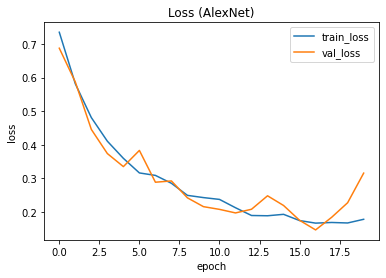

In [ ]:
  fig = plt.figure(figsize=(6, 4))
  plt.plot(train_loss,label="train_loss")
  plt.plot(validation_loss,label="val_loss")
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.title("Loss (AlexNet)")

max validaiton accuracy: 0.9432013769363167


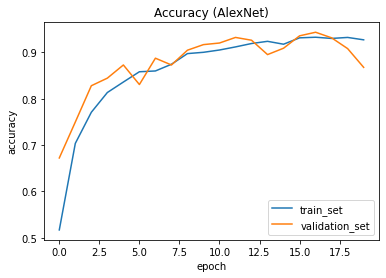

In [ ]:
  fig = plt.figure(figsize=(6, 4))
  plt.plot(train_acc, label="train_set")
  plt.plot(validation_acc, label="validation_set")
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.title("Accuracy (AlexNet)")
  print("max validaiton accuracy:",max(validation_acc))

In [ ]:
test(net, device, test_loader)


Test set: Average loss: 0.2875, Accuracy: 1268/1423 (89.1075%)



89.10751932536894

# Transfer ResNet

In [ ]:
means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225] # required 
preprocess = {"train": transforms.Compose([
                                transforms.RandomRotation(15), # Rotates the images upto Max of 15 Degrees
                                transforms.RandomHorizontalFlip(p=0.2), #Performs Horizantal Flip over images 
                                transforms.Normalize(mean = means, std=stds)]),
              "test": transforms.Compose([transforms.Normalize(mean=means, std=stds)])}

In [ ]:
class TransferResnet50(nn.Module):
    def __init__(self, classes=1):
        super().__init__()
        # Use a pretrained model
        self.res = models.resnet50(pretrained=True)
        for param in self.res.parameters(): # Freeze gradient, transfer Learning
          param.requires_grad = False

        # Replace last layer
        num_ftrs = self.res.fc.in_features
        self.res.fc = nn.Sequential(nn.Linear(num_ftrs, 256), 
                                        nn.ReLU(),  
                                        nn.Dropout(0.25),
                                        nn.Linear(256, 128), 
                                        nn.ReLU(),  
                                        nn.Dropout(0.25),
                                        nn.Linear(128,classes))
    
    def forward(self, xb):
        out = self.res(xb)
        return out


In [ ]:
net2 = TransferResnet50().to(device)            
criterion = nn.BCEWithLogitsLoss() # Loss for binary classification, softmax implemented internally
optimizer = torch.optim.Adam(net2.parameters(), lr=1e-4)
num_epochs = 20
train_loss, train_acc, validation_loss, validation_acc = train(net2, device, train_loader, validation_loader, num_epochs, criterion, optimizer, preprocess)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


Text(0.5, 1.0, 'Loss (ResNet50)')

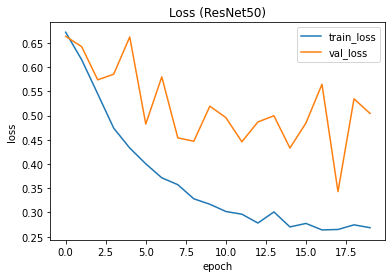

In [ ]:
  fig = plt.figure(figsize=(6, 4))
  plt.plot(train_loss,label="train_loss")
  plt.plot(validation_loss,label="val_loss")
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.title("Loss (ResNet50)")

max validaiton accuracy: 0.8382099827882961


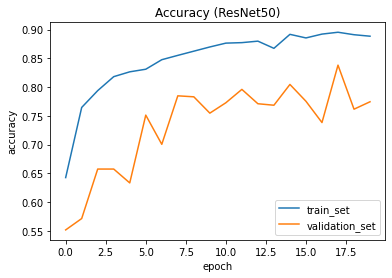

In [ ]:
  fig = plt.figure(figsize=(6, 4))
  plt.plot(train_acc, label="train_set")
  plt.plot(validation_acc, label="validation_set")
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.title("Accuracy (ResNet50)")
  print("max validaiton accuracy:",max(validation_acc))

In [ ]:
test(net2, device, test_loader)


Test set: Average loss: 0.4944, Accuracy: 1104/1423 (77.5826%)



77.58257203092059

# Alexnet + Attention

In [ ]:
class ProjectorBlock(nn.Module):  # normalize size of g and l, project l to g
    def __init__(self, in_features, out_features):
        super(ProjectorBlock, self).__init__()
        self.op = nn.Conv2d(in_channels=in_features, out_channels=out_features, kernel_size=1, padding=0, bias=False)
    def forward(self, inputs):
        return self.op(inputs)

class LinearAttentionBlock(nn.Module):
    def __init__(self, in_features):
        super(LinearAttentionBlock, self).__init__()
        self.op = nn.Conv2d(in_channels=in_features, out_channels=1, kernel_size=1, padding=0, bias=False)
    def forward(self, l, g):
        N, C, W, H = l.size()
        c = self.op(l+g)  # calculate compatibility score
        a = F.softmax(c.view(N,1,-1), dim=2).view(N,1,W,H)  # calculate attention weights
        g = torch.mul(a.expand_as(l), l) # find g_a
        g = g.view(N,C,-1).sum(dim=2) # batch_sizexC
        return c.view(N,1,W,H), g, a

##Attention at second last year without dropout

In [ ]:
'''
Grid attention block
Reference papers
Attention-Gated Networks https://arxiv.org/abs/1804.02391
Reference code
https://github.com/SaoYan/LearnToPayAttention
'''

class AlexNet_attention_nd(nn.Module): # attention at second last layer
    def __init__(self, attention=True) -> None:
        super(AlexNet_attention_nd, self).__init__()
        self.conv1 = nn.Conv2d(3 , 64, 11, 4, 2) 
        self.batchnorm1 = nn.BatchNorm2d(64) # added batchnorm layers
        self.conv2 = nn.Conv2d(64, 192, 5, 2, 2)
        self.batchnorm2 = nn.BatchNorm2d(192)
        self.conv3 = nn.Conv2d(192, 384, 3, 2, 1) 
        self.batchnorm3 = nn.BatchNorm2d(384)
        self.conv4 = nn.Conv2d(384, 256, 3, 1, 1)
        self.batchnorm4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 256, 3, 1, 1) # global feature

        # attention
        self.atten1 = LinearAttentionBlock(256) # after conv4

        self.avgpool = nn.AdaptiveAvgPool2d(6)
        self.maxpool = nn.MaxPool2d(3, 2)
        self.fc1 = nn.Linear(256 , 128) # changed
        # self.fc2 = nn.Linear(4096, 4096) # removed
        self.fc2 = nn.Linear(128, 1) # changed
        self.dropout = nn.Dropout(0.5)
        weights_init_xavierUniform(self)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # convolution layers
        x = self.conv1(x)
        x = F.relu(self.maxpool(x))
        x = self.batchnorm1(x)
        l1 = self.conv2(x)
        x = F.relu(self.maxpool(l1))
        x = self.batchnorm2(x)
        l2 = self.conv3(x)
        x = self.batchnorm3(l2)
        x = self.dropout(x) # added
        x = F.relu(x)
        l3 = self.conv4(x)
        x = self.batchnorm4(l3)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.conv5(x)
        g = F.relu(self.maxpool(x)) # global feature vector

        # x = self.avgpool(g) # 26*256*6*6 , replicated numbers? x[0][0]=0.0146 (6*6 matrix)

        c1, g, a1 = self.atten1(l3, g)
        # fully connected layers
        #x = self.dropout(g)
        #x = torch.flatten(x, 1)
        #print(x.shape)
        x = self.fc1(g)
        x = F.relu(x)
        x = self.fc2(x)
        
        
        return x

In [ ]:
atten = AlexNet_attention_nd().to(device)            
criterion = nn.BCEWithLogitsLoss() # Loss for binary classification, softmax implemented internally
optimizer = torch.optim.Adam(atten.parameters(), lr=1e-4)
num_epochs = 50
train_loss, train_acc, validation_loss, validation_acc = train(atten, device, train_loader, validation_loader, num_epochs, criterion, optimizer, preprocess)

Text(0.5, 1.0, 'Loss (AlexNet + Attn 1)')

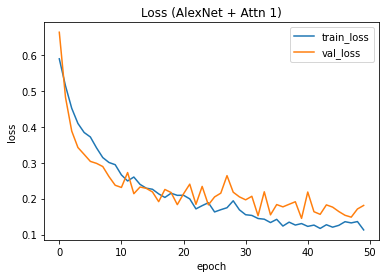

In [ ]:
  # fig = plt.figure(figsize=(8, 6))
  plt.plot(train_loss,label="train_loss")
  plt.plot(validation_loss,label="val_loss")
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.title("Loss (AlexNet + Attn 1)")

max validaiton accuracy: 0.9500860585197934


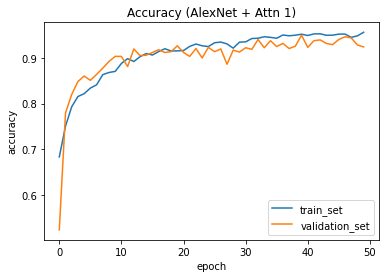

In [ ]:
  # fig = plt.figure(figsize=(8, 6))
  plt.plot(train_acc, label="train_set")
  plt.plot(validation_acc, label="validation_set")
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.title("Accuracy (AlexNet + Attn 1)")
  print("max validaiton accuracy:",max(validation_acc))

In [ ]:
test(atten, device, test_loader)


Test set: Average loss: 0.2053, Accuracy: 1316/1423 (92.4807%)



92.48067463106113

##Attention after conv3, conv4 without dropout

In [ ]:
class AlexNet_attention2_nd(nn.Module): # attention at second last layer
    def __init__(self, attention=True) -> None:
        super(AlexNet_attention2_nd, self).__init__()
        self.conv1 = nn.Conv2d(3 , 64, 11, 4, 2) 
        self.batchnorm1 = nn.BatchNorm2d(64) # added batchnorm layers
        self.conv2 = nn.Conv2d(64, 192, 5, 2, 2)
        self.batchnorm2 = nn.BatchNorm2d(192)
        self.conv3 = nn.Conv2d(192, 384, 3, 2, 1) 
        self.batchnorm3 = nn.BatchNorm2d(384)
        self.conv4 = nn.Conv2d(384, 256, 3, 1, 1)
        self.batchnorm4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 256, 3, 1, 1) # global feature

        # attention
        self.projector1 = ProjectorBlock(384, 256)
        self.atten1 = LinearAttentionBlock(256) # after conv3
        self.atten2 = LinearAttentionBlock(256) # after conv4


        self.avgpool = nn.AdaptiveAvgPool2d(6)
        self.maxpool = nn.MaxPool2d(3, 2)
        self.fc1 = nn.Linear(256*2 , 128) # changed
        # self.fc2 = nn.Linear(4096, 4096) # removed
        self.fc2 = nn.Linear(128, 1) # changed
        self.dropout = nn.Dropout(0.5)
        weights_init_xavierUniform(self)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # convolution layers
        x = self.conv1(x)
        x = F.relu(self.maxpool(x))
        x = self.batchnorm1(x)
        l1 = self.conv2(x)
        x = F.relu(self.maxpool(l1))
        x = self.batchnorm2(x)
        l2 = self.conv3(x)
        x = self.batchnorm3(l2)
        x = self.dropout(x) # added
        x = F.relu(x)
        l3 = self.conv4(x)
        x = self.batchnorm4(l3)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.conv5(x)
        g = F.relu(self.maxpool(x)) # global feature vector

        # x = self.avgpool(g) # 26*256*6*6 , replicated numbers? x[0][0]=0.0146 (6*6 matrix)
        l2_projected = self.projector1(l2)
        c1, g1, a1 = self.atten1(l2_projected, g)
        c2, g2, a2 = self.atten2(l3, g)
        g = g = torch.cat((g1,g2), dim=1)

        # fully connected layers
        # x = self.dropout(g)
        # x = torch.flatten(x, 1)
        x = self.fc1(g)
        x = F.relu(x)
        x = self.fc2(x)
        
        
        return x

In [ ]:
atten2 = AlexNet_attention2_nd().to(device)            
criterion = nn.BCEWithLogitsLoss() # Loss for binary classification, softmax implemented internally
optimizer = torch.optim.Adam(atten2.parameters(), lr=1e-4)
num_epochs = 100
train_loss, train_acc, validation_loss, validation_acc = train(atten2, device, train_loader, validation_loader, num_epochs, criterion, optimizer, preprocess)

Text(0.5, 1.0, 'loss')

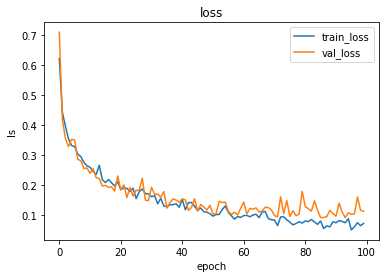

In [ ]:
  # fig = plt.figure(figsize=(8, 6))
  plt.plot(train_loss,label="train_loss")
  plt.plot(validation_loss,label="val_loss")
  plt.xlabel('epoch')
  plt.ylabel('ls')
  plt.legend()
  plt.title("loss")

max validaiton accuracy: 0.9724612736660929


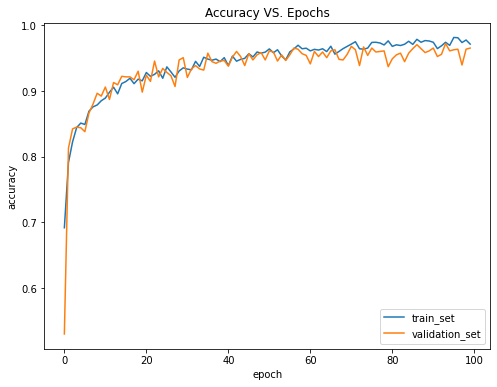

In [ ]:
  fig = plt.figure(figsize=(8, 6))
  plt.plot(train_acc, label="train_set")
  plt.plot(validation_acc, label="validation_set")
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.title("Accuracy VS. Epochs")
  print("max validaiton accuracy:",max(validation_acc))

In [ ]:
test(atten2, device, test_loader)


Test set: Average loss: 0.1001, Accuracy: 1378/1423 (96.8377%)



96.83766690091356

##Attention after conv2, conv3, conv4 without dropout

In [ ]:
def train(model, device, train_loader, validation_loader, epochs, criterion, optimizer, preprocess):

    train_loss, validation_loss = [], []
    train_acc, validation_acc = [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.
        correct, total = 0, 0 
        with tqdm(train_loader, unit='batch') as tepoch:
            tepoch.set_description('Training: ')
            for data, target in tepoch:
                #data, target = preprocess(data.to(device)), target.to(device) # Augmented data
                data,target=preprocess["train"](data.to(device)),target.to(device)
                optimizer.zero_grad()
                # this is only used for attention after conv2,3,4 for visualization purpose
                output, _, _, _ = model(data)

                # this is for other models
                # output = model(data)
                target = torch.unsqueeze(target, 1)

                loss = criterion(output, target.float())
                loss.backward()
                optimizer.step()
                tepoch.set_postfix(loss=loss.item())
                running_loss += loss.item()

                predicted = torch.where(output>0, 1, 0)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        
        train_loss.append(running_loss/len(train_loader))
        train_acc.append(correct/total)      
                
        model.eval()
        running_loss = 0.
        correct, total = 0, 0 
        with tqdm(validation_loader, unit='batch') as tepoch:
            tepoch.set_description('Validation: ')
            for data, target in tepoch:
                # model.eval()
                data, target = preprocess["test"](data.to(device)), target.to(device)
                # this is only used for attention after conv2,3,4 for visualization purpose
                output, _, _, _ = model(data)

                # this is for other models
                # output = model(data)
                target = torch.unsqueeze(target, 1)

                loss = criterion(output, target.float())
                tepoch.set_postfix(loss=loss.item())
                running_loss += loss.item()

                predicted = torch.where(output>0, 1, 0)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        
        validation_loss.append(running_loss/len(validation_loader))
        validation_acc.append(correct/total)
         
    
    return train_loss, train_acc, validation_loss, validation_acc 

In [ ]:
class AlexNet_attention3_nd(nn.Module): # attention at second last layer
    def __init__(self, attention=True) -> None:
        super(AlexNet_attention3_nd, self).__init__()
        self.conv1 = nn.Conv2d(3 , 64, 11, 4, 2) 
        self.batchnorm1 = nn.BatchNorm2d(64) # added batchnorm layers
        self.conv2 = nn.Conv2d(64, 192, 5, 2, 2)
        self.batchnorm2 = nn.BatchNorm2d(192)
        self.conv3 = nn.Conv2d(192, 384, 3, 2, 1) 
        self.batchnorm3 = nn.BatchNorm2d(384)
        self.conv4 = nn.Conv2d(384, 256, 3, 1, 1)
        self.batchnorm4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 256, 3, 1, 1) # global feature

        # attention
        self.projector1 = ProjectorBlock(192, 256)
        self.projector2 = ProjectorBlock(384, 256)
        self.atten1 = LinearAttentionBlock(256) # after conv2
        self.atten2 = LinearAttentionBlock(256) # after conv3
        self.atten3 = LinearAttentionBlock(256) # after conv4

        self.avgpool = nn.AdaptiveAvgPool2d(6)
        self.maxpool = nn.MaxPool2d(3, 2)
        self.fc1 = nn.Linear(256*3 , 128) # changed
        # self.fc2 = nn.Linear(4096, 4096) # removed
        self.fc2 = nn.Linear(128, 1) # changed
        self.dropout = nn.Dropout(0.5)
        weights_init_xavierUniform(self)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # convolution layers
        x = self.conv1(x)
        x = F.relu(self.maxpool(x))
        x = self.batchnorm1(x)
        l1 = self.conv2(x)
        x = F.relu(self.maxpool(l1))
        x = self.batchnorm2(x)
        l2 = self.conv3(x)
        x = self.batchnorm3(l2)
        x = self.dropout(x) # added
        x = F.relu(x)
        l3 = self.conv4(x)
        x = self.batchnorm4(l3)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.conv5(x)
        g = F.relu(self.maxpool(x)) # global feature vector

        # x = self.avgpool(g) # 26*256*6*6 , replicated numbers? x[0][0]=0.0146 (6*6 matrix)
        l1_projected = self.projector1(l1)
        l2_projected = self.projector2(l2)
        c1, g1, a1 = self.atten1(l1_projected, g)
        c2, g2, a2 = self.atten2(l2_projected, g)
        c3, g3, a3 = self.atten2(l3, g)
        g = g = torch.cat((g1,g2, g3), dim=1)

        # fully connected layers
        x = self.fc1(g)
        x = F.relu(x)
        x = self.fc2(x)     
        
        return [x, a1, a2, a3]

In [ ]:
atten3 = AlexNet_attention3_nd().to(device)            
criterion = nn.BCEWithLogitsLoss() # Loss for binary classification, softmax implemented internally
optimizer = torch.optim.Adam(atten3.parameters(), lr=1e-4)
num_epochs = 50 # tried 100, overfitting
train_loss, train_acc, validation_loss, validation_acc = train(atten3, device, train_loader, validation_loader, num_epochs, criterion, optimizer, preprocess)

Text(0.5, 1.0, 'Loss (AlexNet + Attn 3)')

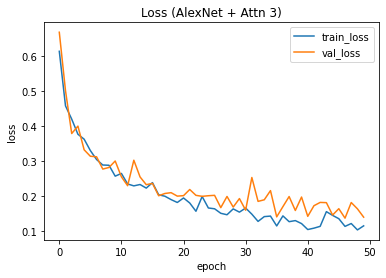

In [ ]:
  # fig = plt.figure(figsize=(8, 6))
  plt.plot(train_loss,label="train_loss")
  plt.plot(validation_loss,label="val_loss")
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.title("Loss (AlexNet + Attn 3)")

max validaiton accuracy: 0.9526678141135972


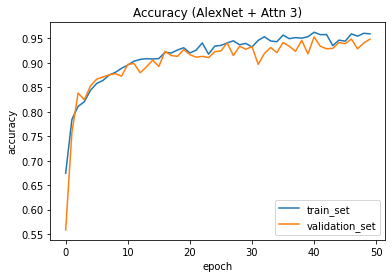

In [ ]:
  # fig = plt.figure(figsize=(8, 6))
  plt.plot(train_acc, label="train_set")
  plt.plot(validation_acc, label="validation_set")
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.title("Accuracy (AlexNet + Attn 3)")
  print("max validaiton accuracy:",max(validation_acc))

In [ ]:
test(atten3, device, test_loader)


Test set: Average loss: 0.1562, Accuracy: 1343/1423 (94.3781%)



94.378074490513

##Visualize Attention (AlexNet + Attention 3 w/o dropout)

In [ ]:
def test_vis(model, device, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
      for data, target in test_loader:
          data, target = preprocess["test"](data.to(device)), target.to(device)
          output, a1, a2, a3 = model(data)

          target = torch.unsqueeze(target, 1)
          test_loss += F.binary_cross_entropy_with_logits(output, target.float(), reduction='sum').item()  
          pred = torch.where(output>0, 1, 0) # get the index of the max log-probability
          correct += pred.eq(target.view_as(pred)).sum().item()

          # each layer of attention weights
          vis1 = visualize_attn_softmax(a1, 2, 6)
          vis2 = visualize_attn_softmax(a2, 2, 6)
          vis3 = visualize_attn_softmax(a3, 2, 6)
          vis1 = vis1.numpy()
          vis2 = vis2.numpy()
          vis3 = vis3.numpy()

          fig = plt.figure(figsize=(10, 50))
          rows = 5
          columns = 3
          fig.add_subplot(rows, columns, 1)
          plt.imshow(vis1)
          fig.add_subplot(rows, columns, 2)
          plt.imshow(vis2)
          fig.add_subplot(rows, columns, 3)
          plt.imshow(vis3)
  
  test_loss /= len(test_loader.dataset)

  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))
  return 100. * correct / len(test_loader.dataset)

In [ ]:
def visualize_attn_softmax(a, up_factor, nrow):
    # heatmap using attention weights
    N,C,W,H = a.size()
    if up_factor > 1:
        a = F.interpolate(a, scale_factor=up_factor, mode='bilinear', align_corners=False)
    attn = utils.make_grid(a, nrow=nrow, normalize=True, scale_each=True)
    attn = attn.permute((1,2,0)).mul(255).byte().cpu().numpy()
    attn = cv2.applyColorMap(attn, cv2.COLORMAP_JET)
    attn = cv2.cvtColor(attn, cv2.COLOR_BGR2RGB)
    attn = np.float32(attn) / 255

    return torch.from_numpy(attn)


Test set: Average loss: 0.0068, Accuracy: 4/4 (100.0000%)



100.0

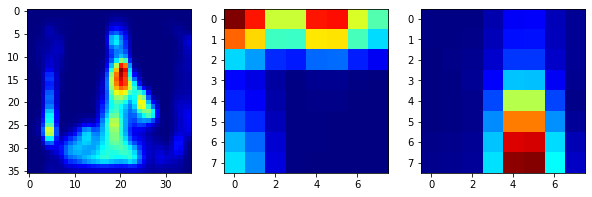

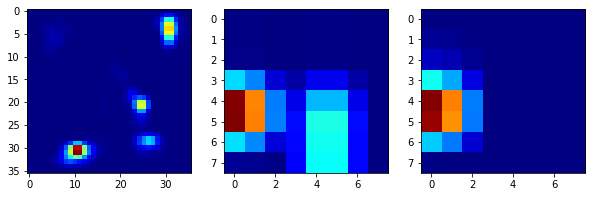

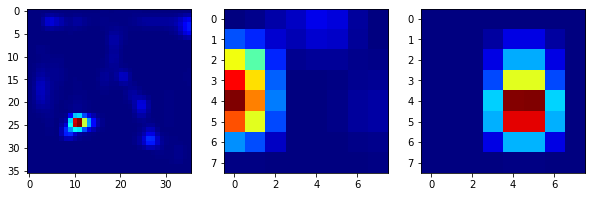

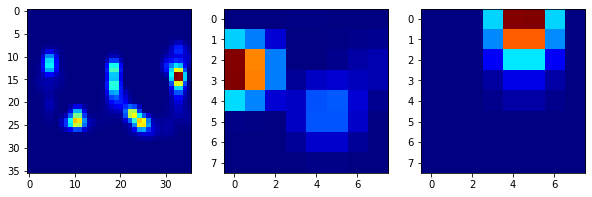

In [ ]:
# display 2 attention layers for 5 test examples
subset_indices = [0, 1, 2, 3]
subset = torch.utils.data.Subset(test_set, subset_indices)
testloader_subset = torch.utils.data.DataLoader(subset, batch_size=1, num_workers=0, shuffle=False)
test_vis(atten3, device, testloader_subset)

In [ ]:
def test_vis(model, device, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  i = 0
  with torch.no_grad():
      for data, target in test_loader:
          data, target = preprocess["test"](data.to(device)), target.to(device)
          output, a1, a2, a3 = model(data)

          target = torch.unsqueeze(target, 1)
          test_loss += F.binary_cross_entropy_with_logits(output, target.float(), reduction='sum').item()  
          pred = torch.where(output>0, 1, 0) # get the index of the max log-probability
          correct += pred.eq(target.view_as(pred)).sum().item()

          if(i < 1):
            # each layer of attention weights
            vis1 = visualize_attn_softmax(a1, 2, 6)
            vis1 = vis1.numpy()

            plt.rcParams["figure.figsize"] = (150,150)
            plt.imshow(vis1)
            plt.figure()
          i+=1
  
  test_loss /= len(test_loader.dataset)

  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))
  return 100. * correct / len(test_loader.dataset)


Test set: Average loss: 0.1562, Accuracy: 1343/1423 (94.3781%)



94.378074490513

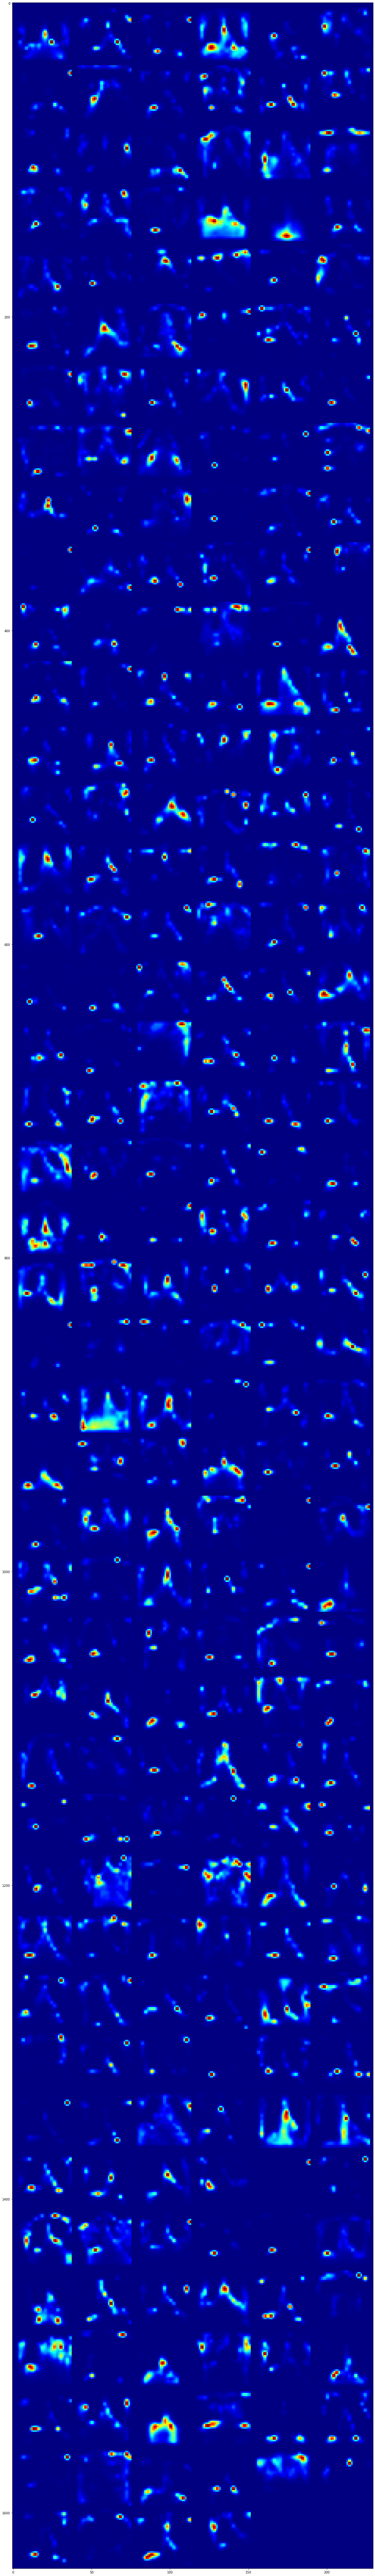

<Figure size 10800x10800 with 0 Axes>

In [ ]:
test_vis(atten3, device, test_loader)

## Attention at second last layer

In [ ]:
'''
Grid attention block
Reference papers
Attention-Gated Networks https://arxiv.org/abs/1804.02391
Reference code
https://github.com/SaoYan/LearnToPayAttention
'''

class AlexNet_attention(nn.Module): # attention at second last layer
    def __init__(self, attention=True) -> None:
        super(AlexNet_attention, self).__init__()
        self.conv1 = nn.Conv2d(3 , 64, 11, 4, 2) 
        self.batchnorm1 = nn.BatchNorm2d(64) # added batchnorm layers
        self.conv2 = nn.Conv2d(64, 192, 5, 2, 2)
        self.batchnorm2 = nn.BatchNorm2d(192)
        self.conv3 = nn.Conv2d(192, 384, 3, 2, 1) 
        self.batchnorm3 = nn.BatchNorm2d(384)
        self.conv4 = nn.Conv2d(384, 256, 3, 1, 1)
        self.batchnorm4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 256, 3, 1, 1) # global feature

        # attention
        self.atten1 = LinearAttentionBlock(256) # after conv4

        self.avgpool = nn.AdaptiveAvgPool2d(6)
        self.maxpool = nn.MaxPool2d(3, 2)
        self.fc1 = nn.Linear(256 , 128) # changed
        # self.fc2 = nn.Linear(4096, 4096) # removed
        self.fc2 = nn.Linear(128, 1) # changed
        self.dropout = nn.Dropout(0.5)
        weights_init_xavierUniform(self)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # convolution layers
        x = self.conv1(x)
        x = F.relu(self.maxpool(x))
        x = self.batchnorm1(x)
        l1 = self.conv2(x)
        x = F.relu(self.maxpool(l1))
        x = self.batchnorm2(x)
        l2 = self.conv3(x)
        x = self.batchnorm3(l2)
        x = self.dropout(x) # added
        x = F.relu(x)
        l3 = self.conv4(x)
        x = self.batchnorm4(l3)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.conv5(x)
        g = F.relu(self.maxpool(x)) # global feature vector

        # x = self.avgpool(g) # 26*256*6*6 , replicated numbers? x[0][0]=0.0146 (6*6 matrix)

        c1, g, a1 = self.atten1(l3, g)
        # fully connected layers
        x = self.dropout(g)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        
        return x

In [ ]:
atten = AlexNet_attention().to(device)            
criterion = nn.BCEWithLogitsLoss() # Loss for binary classification, softmax implemented internally
optimizer = torch.optim.Adam(atten.parameters(), lr=1e-4)
num_epochs = 50
train_loss, train_acc, validation_loss, validation_acc = train(atten, device, train_loader, validation_loader, num_epochs, criterion, optimizer, preprocess)

Text(0.5, 1.0, 'loss')

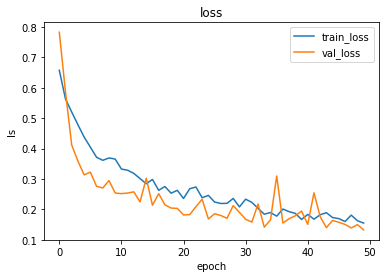

In [ ]:
  # fig = plt.figure(figsize=(8, 6))
  plt.plot(train_loss,label="train_loss")
  plt.plot(validation_loss,label="val_loss")
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.title("Loss (AlexNet + Attn 1)")

max validaiton accuracy: 0.9475043029259896


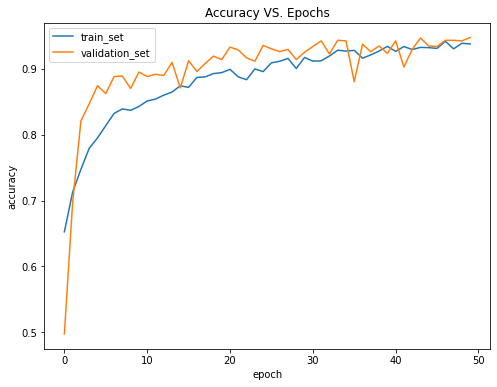

In [ ]:
  # fig = plt.figure(figsize=(8, 6))
  plt.plot(train_acc, label="train_set")
  plt.plot(validation_acc, label="validation_set")
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.title("Accuracy (AlexNet + Attn 1)")
  print("max validaiton accuracy:",max(validation_acc))

In [ ]:
test(atten, device, test_loader)


Test set: Average loss: 0.1499, Accuracy: 1341/1423 (94.2375%)



94.23752635277583

## Attention after conv3, conv4




In [ ]:
class AlexNet_attention2(nn.Module): # attention at second last layer
    def __init__(self, attention=True) -> None:
        super(AlexNet_attention2, self).__init__()
        self.conv1 = nn.Conv2d(3 , 64, 11, 4, 2) 
        self.batchnorm1 = nn.BatchNorm2d(64) # added batchnorm layers
        self.conv2 = nn.Conv2d(64, 192, 5, 2, 2)
        self.batchnorm2 = nn.BatchNorm2d(192)
        self.conv3 = nn.Conv2d(192, 384, 3, 2, 1) 
        self.batchnorm3 = nn.BatchNorm2d(384)
        self.conv4 = nn.Conv2d(384, 256, 3, 1, 1)
        self.batchnorm4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 256, 3, 1, 1) # global feature

        # attention
        self.projector1 = ProjectorBlock(384, 256)
        self.atten1 = LinearAttentionBlock(256) # after conv3
        self.atten2 = LinearAttentionBlock(256) # after conv4


        self.avgpool = nn.AdaptiveAvgPool2d(6)
        self.maxpool = nn.MaxPool2d(3, 2)
        self.fc1 = nn.Linear(256*2 , 128) # changed
        # self.fc2 = nn.Linear(4096, 4096) # removed
        self.fc2 = nn.Linear(128, 1) # changed
        self.dropout = nn.Dropout(0.5)
        weights_init_xavierUniform(self)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # convolution layers
        x = self.conv1(x)
        x = F.relu(self.maxpool(x))
        x = self.batchnorm1(x)
        l1 = self.conv2(x)
        x = F.relu(self.maxpool(l1))
        x = self.batchnorm2(x)
        l2 = self.conv3(x)
        x = self.batchnorm3(l2)
        x = self.dropout(x) # added
        x = F.relu(x)
        l3 = self.conv4(x)
        x = self.batchnorm4(l3)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.conv5(x)
        g = F.relu(self.maxpool(x)) # global feature vector

        # x = self.avgpool(g) # 26*256*6*6 , replicated numbers? x[0][0]=0.0146 (6*6 matrix)
        l2_projected = self.projector1(l2)
        c1, g1, a1 = self.atten1(l2_projected, g)
        c2, g2, a2 = self.atten2(l3, g)
        g = g = torch.cat((g1,g2), dim=1)

        # fully connected layers
        x = self.dropout(g)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        
        return x

In [ ]:
atten2 = AlexNet_attention2().to(device)            
criterion = nn.BCEWithLogitsLoss() # Loss for binary classification, softmax implemented internally
optimizer = torch.optim.Adam(atten2.parameters(), lr=1e-4)
num_epochs = 100
train_loss, train_acc, validation_loss, validation_acc = train(atten2, device, train_loader, validation_loader, num_epochs, criterion, optimizer, preprocess)

Text(0.5, 1.0, 'loss')

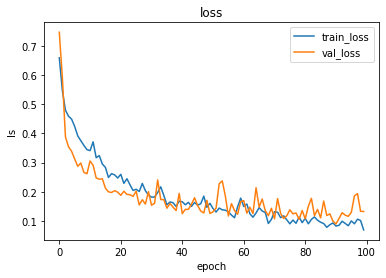

In [ ]:
  # fig = plt.figure(figsize=(8, 6))
  plt.plot(train_loss,label="train_loss")
  plt.plot(validation_loss,label="val_loss")
  plt.xlabel('epoch')
  plt.ylabel('ls')
  plt.legend()
  plt.title("loss")

max validaiton accuracy: 0.9707401032702238


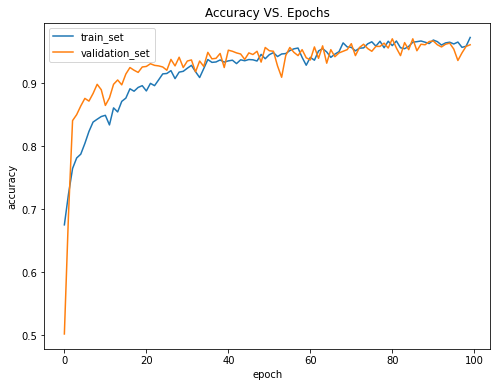

In [ ]:
  fig = plt.figure(figsize=(8, 6))
  plt.plot(train_acc, label="train_set")
  plt.plot(validation_acc, label="validation_set")
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.title("Accuracy VS. Epochs")
  print("max validaiton accuracy:",max(validation_acc))

In [ ]:
test(atten2, device, test_loader)


Test set: Average loss: 0.1437, Accuracy: 1343/1423 (94.3781%)



94.378074490513

## Attention after conv2, conv3, conv4

In [ ]:
class AlexNet_attention3(nn.Module): # attention at second last layer
    def __init__(self, attention=True) -> None:
        super(AlexNet_attention3, self).__init__()
        self.conv1 = nn.Conv2d(3 , 64, 11, 4, 2) 
        self.batchnorm1 = nn.BatchNorm2d(64) # added batchnorm layers
        self.conv2 = nn.Conv2d(64, 192, 5, 2, 2)
        self.batchnorm2 = nn.BatchNorm2d(192)
        self.conv3 = nn.Conv2d(192, 384, 3, 2, 1) 
        self.batchnorm3 = nn.BatchNorm2d(384)
        self.conv4 = nn.Conv2d(384, 256, 3, 1, 1)
        self.batchnorm4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 256, 3, 1, 1) # global feature

        # attention
        self.projector1 = ProjectorBlock(192, 256)
        self.projector2 = ProjectorBlock(384, 256)
        self.atten1 = LinearAttentionBlock(256) # after conv2
        self.atten2 = LinearAttentionBlock(256) # after conv3
        self.atten3 = LinearAttentionBlock(256) # after conv4

        self.avgpool = nn.AdaptiveAvgPool2d(6)
        self.maxpool = nn.MaxPool2d(3, 2)
        self.fc1 = nn.Linear(256*3 , 128) # changed
        # self.fc2 = nn.Linear(4096, 4096) # removed
        self.fc2 = nn.Linear(128, 1) # changed
        self.dropout = nn.Dropout(0.5)
        weights_init_xavierUniform(self)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # convolution layers
        x = self.conv1(x)
        x = F.relu(self.maxpool(x))
        x = self.batchnorm1(x)
        l1 = self.conv2(x)
        x = F.relu(self.maxpool(l1))
        x = self.batchnorm2(x)
        l2 = self.conv3(x)
        x = self.batchnorm3(l2)
        x = self.dropout(x) # added
        x = F.relu(x)
        l3 = self.conv4(x)
        x = self.batchnorm4(l3)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.conv5(x)
        g = F.relu(self.maxpool(x)) # global feature vector

        # x = self.avgpool(g) # 26*256*6*6 , replicated numbers? x[0][0]=0.0146 (6*6 matrix)
        l1_projected = self.projector1(l1)
        l2_projected = self.projector2(l2)
        c1, g1, a1 = self.atten1(l1_projected, g)
        c2, g2, a2 = self.atten2(l2_projected, g)
        c3, g3, a3 = self.atten2(l3, g)
        g = g = torch.cat((g1,g2, g3), dim=1)

        # fully connected layers
        x = self.dropout(g)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)     
        
        return [x, a1, a2, a3]

In [ ]:
atten3 = AlexNet_attention3().to(device)            
criterion = nn.BCEWithLogitsLoss() # Loss for binary classification, softmax implemented internally
optimizer = torch.optim.Adam(atten3.parameters(), lr=1e-4)
num_epochs = 30 # tried 100, overfitting
train_loss, train_acc, validation_loss, validation_acc = train(atten3, device, train_loader, validation_loader, num_epochs, criterion, optimizer, preprocess)

Text(0.5, 1.0, 'loss')

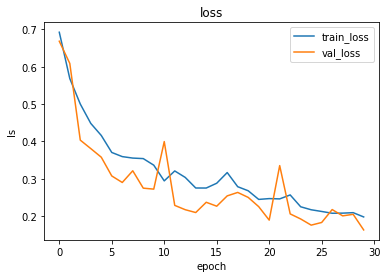

In [ ]:
  # fig = plt.figure(figsize=(8, 6))
  plt.plot(train_loss,label="train_loss")
  plt.plot(validation_loss,label="val_loss")
  plt.xlabel('epoch')
  plt.ylabel('ls')
  plt.legend()
  plt.title("loss")

max validaiton accuracy: 0.9328743545611016


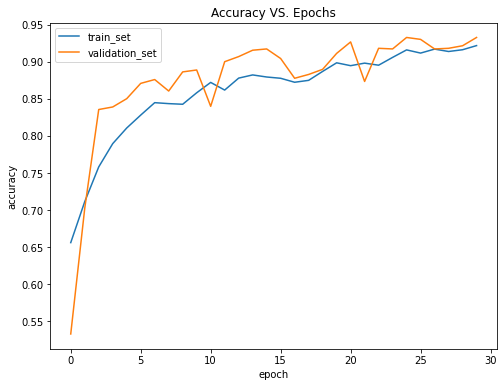

In [ ]:
  fig = plt.figure(figsize=(8, 6))
  plt.plot(train_acc, label="train_set")
  plt.plot(validation_acc, label="validation_set")
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.title("Accuracy VS. Epochs")
  print("max validaiton accuracy:",max(validation_acc))

In [ ]:
test(atten3, device, test_loader)


Test set: Average loss: 0.1892, Accuracy: 1315/1423 (92.4104%)



92.41040056219255